In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [106]:
U = 1
D = 5
H =5*D
L = 35*D
N = 100
mu = 5
c = 100
M = U/c
Re= U*D/mu
Re

1.0

In [192]:
y = np.linspace(0, H-1, 50)
x = np.linspace(0, L-1, 100)
X, Y = np.meshgrid(x, y)

print(np.shape(X), np.shape(Y))
rho = np.ones(np.shape(X))
u = np.ones(np.shape(X)) *U
v = np.zeros(np.shape(X))


dx = x[1] - x[0]
dy = y[1] - y[0]

dt = 0.01 * 0.9*M*dx / np.sqrt(2)


(50, 100) (50, 100)


In [193]:
#rho[0,1] = 5
#print(rho)
#print(np.roll(rho, 1, 0), np.roll(rho, 1, 0)[1,1]) #i, j+1
#print(np.roll(rho, 1, 1), np.roll(rho, 1, 1)[0,2]) #i+1,j

In [194]:
rho = np.ones(np.shape(X))

#front
rho[1*D:2*D, 2*D] = 2

#back
rho[1*D:2*D, 3*D] = 2

#top
rho[2*D-1, 2*D:3*D+1] = 5

#bottom
rho[D-1, 2*D:3*D+1]=5



rho[1*D:2*D-1, 2*D+1:3*D]=9

print(rho)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [195]:
c1 = dt/dx
c2 = dt/dy
c3 = mu*dt/dx**2
c4 = mu*dt/dy**2
c5 = mu*dt/(12*dx*dy) 

In [233]:
def predictor_step(rho, u, v):
    #rho, u, v= square(rho, u, v)

    rho_new = rho - c1 * (np.roll(rho*u, 1, 1) - rho*u) - c2 * (np.roll(rho*v, 1, 0) - rho*v)
    
    
    u_new = (rho*u - 
         c1* (np.roll(rho*u**2+c**2*rho, 1, 1) - (rho*u**2+c**2*rho)) - 
         c2* (np.roll(rho*u*v, 1, 0)-rho*u*v) + 
         4/3* c3 * (np.roll(u,1,1)-2*u + np.roll(u,-1,1))
         + c4*(np.roll(u, 1,0) - 2*u + np.roll(u,-1, 0))
         + c5 * (np.roll(np.roll(v,1,1),1,0) + np.roll(np.roll(v,-1,1),-1,0) - np.roll(np.roll(v,1,1),-1,0)- np.roll(np.roll(v,-1,1),1,0)))
    
    
    v_new = (rho*v - 
         c2* (np.roll(rho*v**2+c**2*rho, 1, 0) - (rho*v**2+c**2*rho)) - 
         c1* (np.roll(rho*u*v, 1, 1)-rho*u*v) + 
         4/3* c4 * (np.roll(v,1,0)-2*v + np.roll(u,-1,0))
         + c3*(np.roll(v, 1,1) - 2*v + np.roll(v,-1, 1))
         + c5 * (np.roll(np.roll(u,1,1),1,0) + np.roll(np.roll(u,-1,1),-1,0) - np.roll(np.roll(u,1,1),-1,0)- np.roll(np.roll(u,-1,1),1,0)))

    #front
    rho_new[:,0] = rho[:,0] - dt/(2*dx)*(-np.roll(u[:,0], 2) + 4*np.roll(u[:,0], 1) - 3*u[:,0])

    #back
    rho_new[:,-1] = rho[:,-1] + dt/(2*dx)*(-np.roll(u[:,0], -2) + 4*np.roll(u[:,0], -1) - 3*u[:,0]) 
    
    #top
    rho_new[-1,:] = (rho[-1,:] - dt*U/(2*dx) * (np.roll(rho[-1,:], 1) - np.roll(rho[-1,:], -1)) + 
                    dt/(2*dy)*(-v[-3,:] + 4*v[-2,:]-3*v[-1,:]))
    
    #bottom
    rho_new[0,:] = (rho[0,:] - dt*U/(2*dx) * (np.roll(rho[0,:], 1) - np.roll(rho[0,:], -1)) -
                    dt/(2*dy)*(-v[2,:] + 4*v[1,:]-3*v[0,:]))
    
    u_new = u_new/rho_new
    v_new = v_new/rho_new
    #box:
    rho_new, u_new, v_new = square(rho_new, u_new, v_new)

    

    
    return rho_new, u_new, v_new

In [234]:
def corrector_step(rho, u, v):
    rho_new, u_new, v_new = predictor_step(rho, u, v)
    #rho_new, u_new, v_new = square(rho_new, u_new, v_new)
    rho_final = rho + rho_new - c1*(rho_new*u_new-np.roll(rho_new*u_new,-1,1)) - c2* (rho_new*v_new-np.roll(rho_new*v_new,-1,0))
    rho_final = rho_final/2
    
    
    u_final = (rho*u + rho_new*u_new 
               -c1*( (rho_new*u_new**2+c**2*rho_new) - np.roll(rho_new*u_new**2 + c**2*rho_new, -1, 1))
               -c2*( rho_new*u_new*v_new - np.roll(rho_new*u_new*v_new, -1, 0))
               +4/3*c3*(np.roll(u_new, 1, 1) - 2*u_new + np.roll(u_new, -1, 1))
               +c4*(np.roll(u_new, 1, 0) - 2*u_new + np.roll(u_new, -1, 0))
               +c5*(np.roll(np.roll(v,1,1),1,0) + np.roll(np.roll(v,-1,1),-1,0) - np.roll(np.roll(v,1,1),-1,0)- np.roll(np.roll(v,-1,1),1,0)))
    
    
    v_final = (rho*v + rho_new*v_new 
               -c2*( (rho_new*v_new**2+c**2*rho_new) - np.roll(rho_new*v_new**2 + c**2*rho_new, -1, 0))
               -c1*( rho_new*u_new*v_new - np.roll(rho_new*u_new*v_new, -1, 1))
               +4/3*c4*(np.roll(v_new, 1, 0) - 2*v_new + np.roll(v_new, -1, 0))
               +c3*(np.roll(v_new, 1, 1) - 2*v_new + np.roll(v_new, -1, 1))
               +c5*(np.roll(np.roll(u,1,1),1,0) + np.roll(np.roll(u,-1,1),-1,0) - np.roll(np.roll(u,1,1),-1,0)- np.roll(np.roll(u,-1,1),1,0)))
    
    
    
    #top:
    rho_final[-1,:] = (rho[-1,:] + rho_new[-1,:] - dt*U/(2*dx)*(np.roll(rho_new[-1,:], 1) - np.roll(rho_new[-1,:], -1)) + 
                        dt/(2*dy)*(-v_new[-3,:] + 4*v_new[-2,:]-3*v_new[-1,:]))
    rho_final[-1,:] = rho_final[-1,:]/2
    
    #bottom
    rho_final[0,:] = (rho[0,:] + rho_new[0,:] - dt*U/(2*dx) * (np.roll(rho_new[0,:], 1) - np.roll(rho_new[0,:], -1)) -
                    dt/(2*dy)*(-v_new[2,:] + 4*v_new[1,:]-3*v_new[0,:]))
    rho_final[0,:]=rho_final[0,:]/2
    
    
    #front
    rho_final[:,0]=rho[:,0] + rho_new[:,0] - dt/(2*dx) * (-np.roll(u_new[:,0], 2) + 4*np.roll(u_new[:,0], 1) - 3*rho_new[:,0]*u_new[:,0])
    
    #back
    rho_final[:,-1]=rho[:,-1] + rho_new[:,-1] + dt/(2*dx)*(-np.roll(u_new[:,0], -2) + 4*np.roll(u_new[:,0], -1) - 3*rho_new[:,0]*u_new[:,0])
    
    
    u_final = u_final/(2*rho_final)
    v_final = v_final/(2*rho_final)
    
    
    
    #Box
    rho_final, u_final, v_final = square(rho_final, u_final, v_final)
    
    return rho_final, u_final, v_final
    

In [235]:
#rho[1*D-1:2*D, 2*D] = 5 #front
#rho[1*D-1:2*D, 3*D] = 5 #back
#rho[D-1, 2*D:3*D] = 5 #bottom
#rho[2*D-1, 2*D:3*D] = 5 #top

def square(rho, u, v):
    #front
    rho[1*D:2*D, 2*D] =( 1/3*( 4* rho[1*D:2*D, 2*D-1]-rho[1*D:2*D, 2*D-2])
                          + 8*M**2/(9*dx*Re) *(-5*u[1*D:2*D, 2*D-1] + 4* u[1*D:2*D, 2*D-2] - u[1*D:2*D, 2*D-3])
                          - M**2/(18*dy*Re)*(- (v[1*D+1:2*D+1, 2*D-2]-v[1*D-1:2*D-1, 2*D-2]) + 4*(v[1*D+1:2*D+1, 2*D-1] - v[1*D-1:2*D-1, 2*D-1]))
                          - 3*(v[1*D+1:2*D+1, 2*D] - v[1*D-1:2*D-1, 2*D])  )
    
    #back
    rho[1*D:2*D, 3*D] = ( 1/3*( 4* rho[1*D:2*D, 3*D+1]-rho[1*D:2*D, 3*D+2])
                          - 8*M**2/(9*dx*Re) *(-5*u[1*D:2*D, 3*D+1] + 4* u[1*D:2*D, 3*D+2] - u[1*D:2*D, 3*D+3])
                          - M**2/(18*dy*Re)*(- (v[1*D+1:2*D+1, 3*D+2]-v[1*D-1:2*D-1, 3*D+2]) + 4*(v[1*D+1:2*D+1, 3*D+1] - v[1*D-1:2*D-1, 3*D+1]))
                          - 3*(v[1*D+1:2*D+1, 3*D] - v[1*D-1:2*D-1, 3*D])  )
    
    #top
    rho[2*D-1, 2*D:3*D+1] = ( 1/3*( 4* rho[2*D-1+1, 2*D:3*D+1]-rho[2*D-1+2, 2*D:3*D+1])
                          - 8*M**2/(9*dy*Re) *(-5*v[2*D-1+1, 2*D:3*D+1] + 4* v[2*D-1+2, 2*D:3*D+1] - v[2*D-1+3, 2*D:3*D+1])
                          - M**2/(18*dx*Re)*(- (u[2*D-1+2, 2*D+1:3*D+1+1]-u[2*D-1+2, 2*D-1:3*D+1-1]) + 4*(u[2*D-1+1, 2*D+1:3*D+1+1] - u[2*D-1+1, 2*D-1:3*D+1-1]))
                          - 3*(u[2*D-1, 2*D+1:3*D+1+1] - u[2*D-1, 2*D-1:3*D+1-1])  )
    
    #bottom
    rho[D-1, 2*D:3*D+1] = ( 1/3*( 4* rho[D-1-1, 2*D:3*D+1]-rho[D-1-2, 2*D:3*D+1])
                          + 8*M**2/(9*dy*Re) *(-5*v[D-1-1, 2*D:3*D+1] + 4* v[D-1-2, 2*D:3*D+1] - v[D-1-3, 2*D:3*D+1])
                          - M**2/(18*dx*Re)*(- (u[D-1-2, 2*D+1:3*D+1+1]-u[D-1-2, 2*D-1:3*D+1-1]) + 4*(u[D-1-1, 2*D+1:3*D+1+1] - u[D-1-1, 2*D-1:3*D+1-1]))
                          - 3*(u[D-1, 2*D+1:3*D+1+1] - u[D-1, 2*D-1:3*D+1-1])  )
    
    #rho[D:2*D-1, 2*D+1:3*D] = 0
    return rho, u, v

In [236]:
def main(T, rho, u, v):
    plt.figure()
    for i in range(T):
        rho, u, v = corrector_step(rho, u, v)


        #plt.plot( np.ones(2)*2*D, np.linspace(1*D-1,2*D, 2))
        #plt.plot( np.ones(2)*3*D, np.linspace(1*D-1,3*D, 2))
        #plt.plot(np.linspace( 2*D,3*D, 2), np.ones(2)*2*(D-1))
        #plt.plot(np.linspace( 2*D,3*D, 2), np.ones(2)*(D-1))
        #print(rho)

        #plt.imshow(rho)
        plt.quiver(x, y, u, v)
        plt.draw()
        plt.pause(0.01)
        plt.clf()

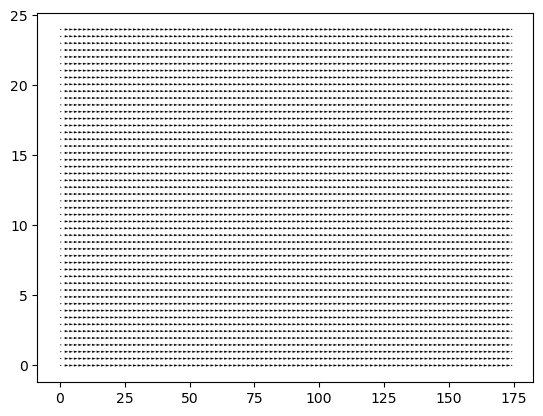

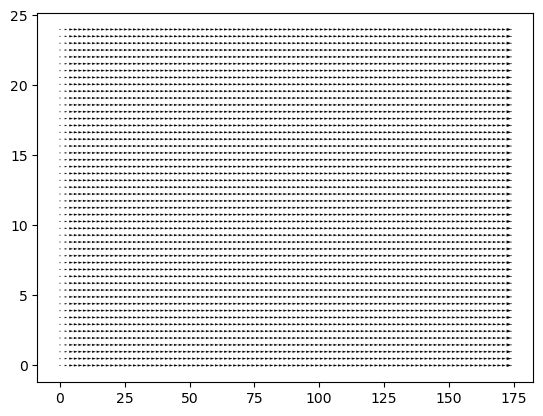

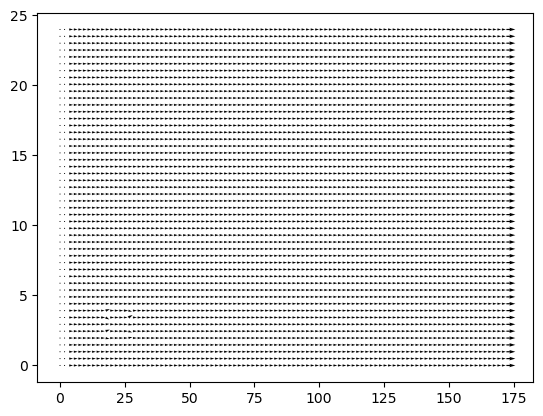

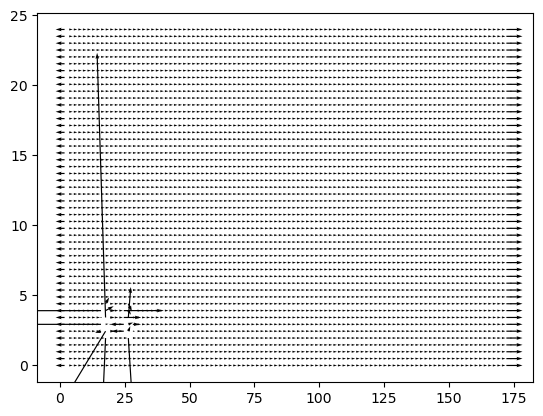

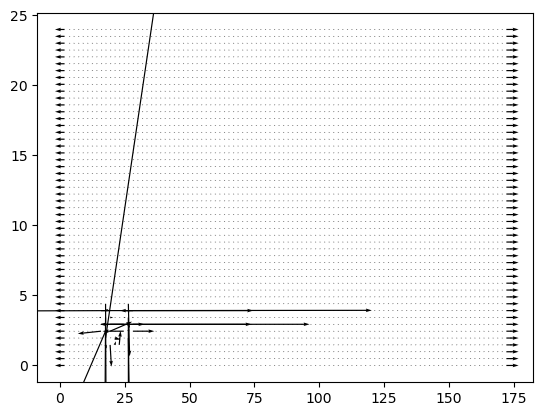

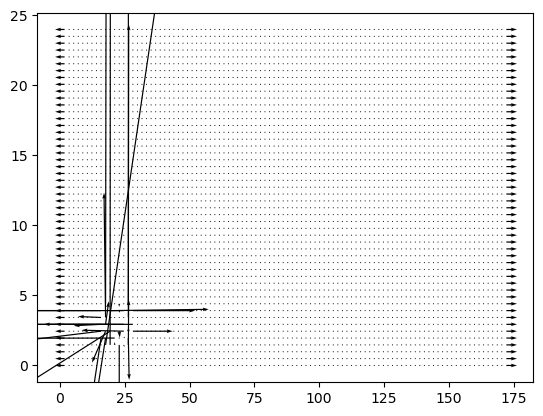

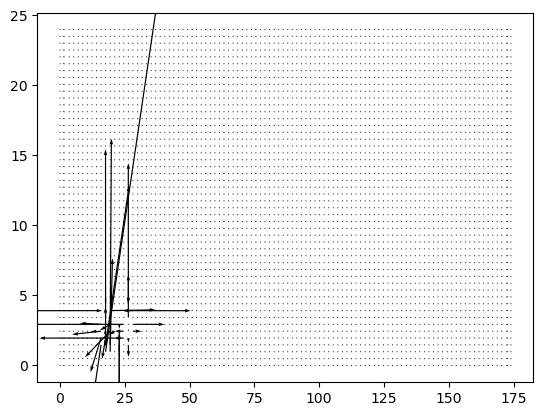

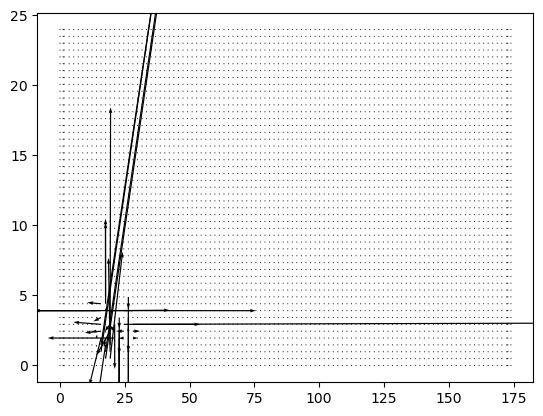

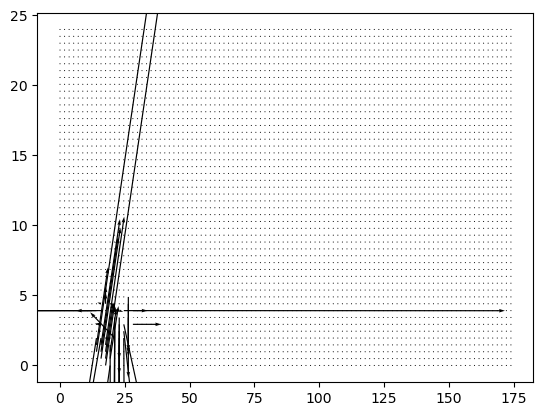

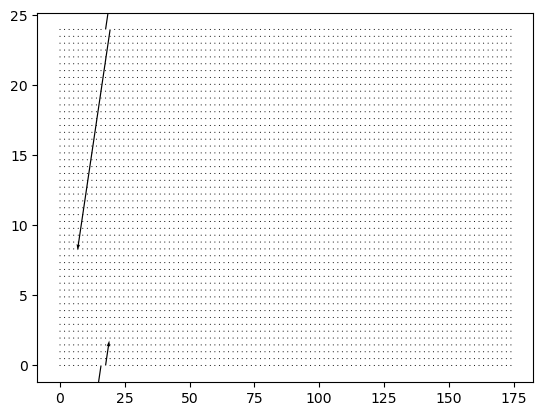

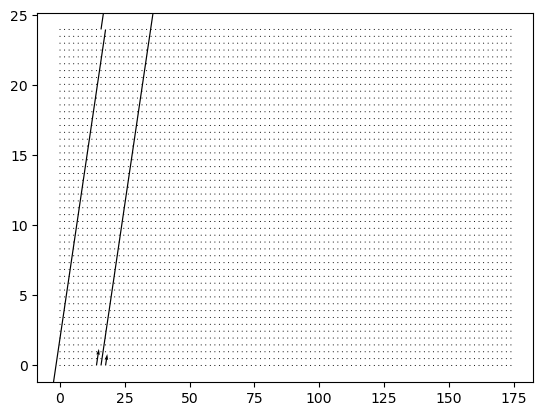

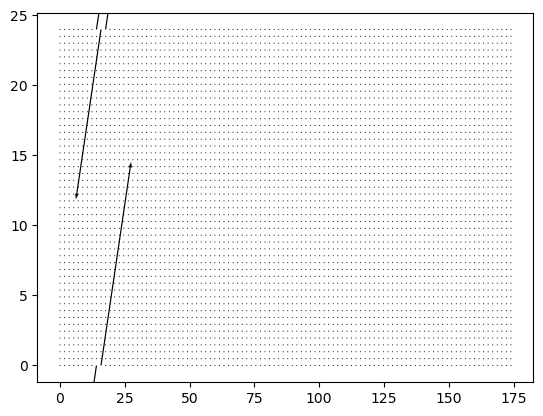

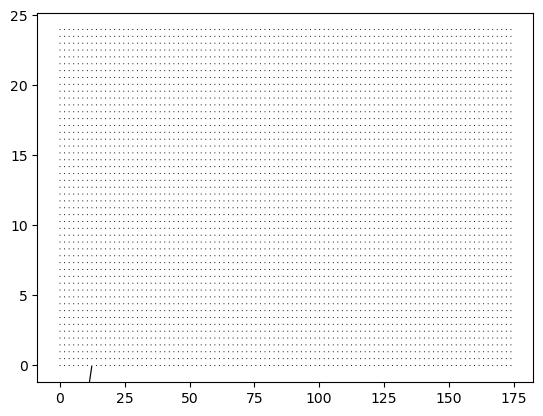

C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:8: RuntimeWarning: overflow encountered in multiply
  c1* (np.roll(rho*u**2+c**2*rho, 1, 1) - (rho*u**2+c**2*rho)) -
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:8: RuntimeWarning: invalid value encountered in subtract
  c1* (np.roll(rho*u**2+c**2*rho, 1, 1) - (rho*u**2+c**2*rho)) -
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:9: RuntimeWarning: overflow encountered in multiply
  c2* (np.roll(rho*u*v, 1, 0)-rho*u*v) +
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:9: RuntimeWarning: invalid value encountered in subtract
  c2* (np.roll(rho*u*v, 1, 0)-rho*u*v) +
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:16: RuntimeWarning: overflow encountered in multiply
  c2* (np.roll(rho*v**2+c**2*rho, 1, 0) - (rho*v**2+c**2*rho)) -
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:16: RuntimeWarning: invalid value encountered in subtract
  c2* (np.

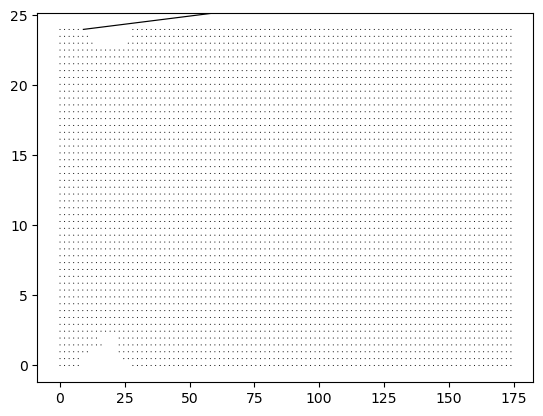

C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:8: RuntimeWarning: overflow encountered in square
  c1* (np.roll(rho*u**2+c**2*rho, 1, 1) - (rho*u**2+c**2*rho)) -
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:7: RuntimeWarning: invalid value encountered in subtract
  u_new = (rho*u -
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:10: RuntimeWarning: invalid value encountered in add
  4/3* c3 * (np.roll(u,1,1)-2*u + np.roll(u,-1,1))
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:7: RuntimeWarning: invalid value encountered in add
  u_new = (rho*u -
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:16: RuntimeWarning: overflow encountered in square
  c2* (np.roll(rho*v**2+c**2*rho, 1, 0) - (rho*v**2+c**2*rho)) -
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:15: RuntimeWarning: invalid value encountered in subtract
  v_new = (rho*v -
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368

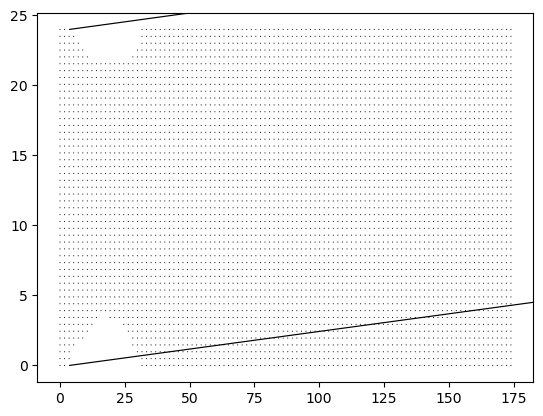

C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:29: RuntimeWarning: invalid value encountered in add
  rho_new[-1,:] = (rho[-1,:] - dt*U/(2*dx) * (np.roll(rho[-1,:], 1) - np.roll(rho[-1,:], -1)) +


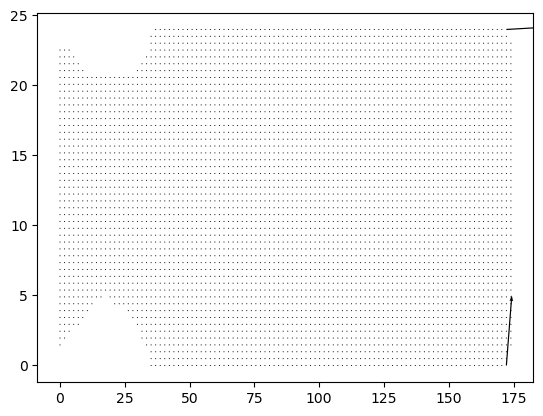

C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:34: RuntimeWarning: invalid value encountered in add
  dt/(2*dy)*(-v[2,:] + 4*v[1,:]-3*v[0,:]))
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\4267363766.py:4: RuntimeWarning: invalid value encountered in multiply
  rho_final = rho + rho_new - c1*(rho_new*u_new-np.roll(rho_new*u_new,-1,1)) - c2* (rho_new*v_new-np.roll(rho_new*v_new,-1,0))
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\4267363766.py:8: RuntimeWarning: invalid value encountered in multiply
  u_final = (rho*u + rho_new*u_new
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\4267363766.py:9: RuntimeWarning: invalid value encountered in multiply
  -c1*( (rho_new*u_new**2+c**2*rho_new) - np.roll(rho_new*u_new**2 + c**2*rho_new, -1, 1))
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\4267363766.py:10: RuntimeWarning: invalid value encountered in multiply
  -c2*( rho_new*u_new*v_new - np.roll(rho_new*u_new*v_new, -1, 0))
C:\Users\caird\AppData\Local\Temp\i

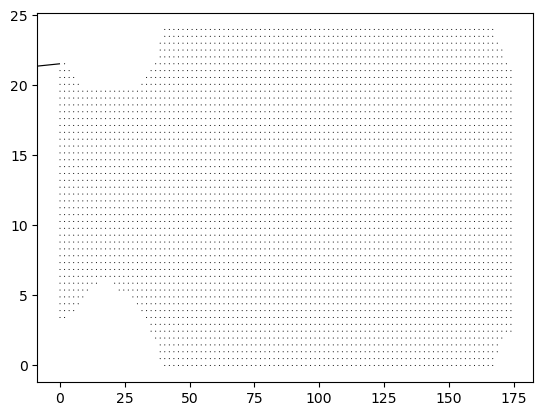

C:\Users\caird\AppData\Local\Temp\ipykernel_16536\4267363766.py:27: RuntimeWarning: invalid value encountered in add
  dt/(2*dy)*(-v_new[-3,:] + 4*v_new[-2,:]-3*v_new[-1,:]))


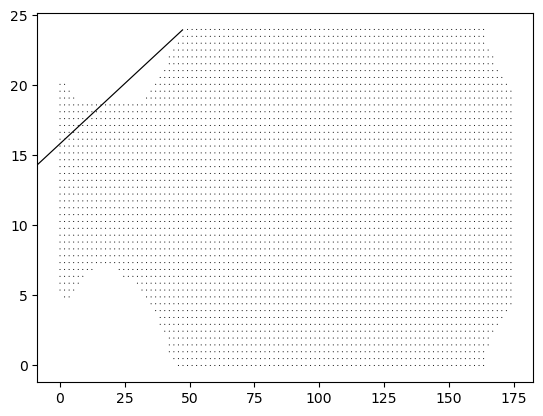

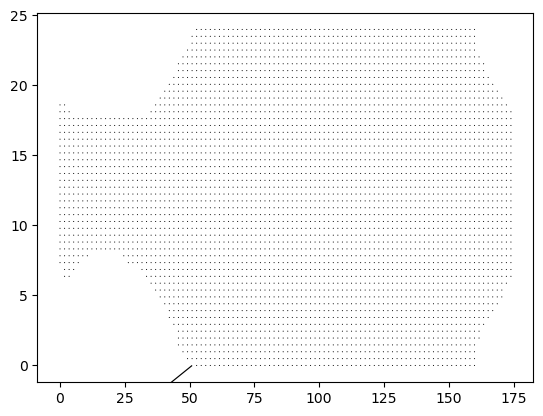

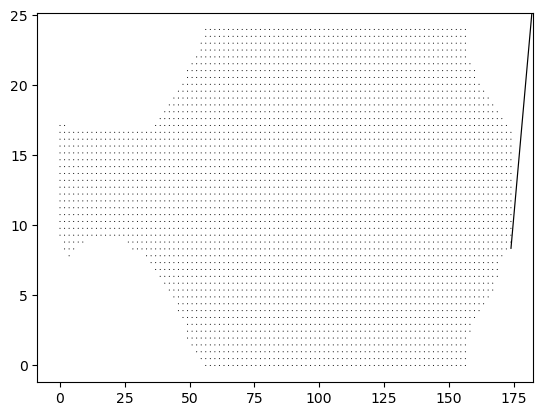

C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:33: RuntimeWarning: invalid value encountered in subtract
  rho_new[0,:] = (rho[0,:] - dt*U/(2*dx) * (np.roll(rho[0,:], 1) - np.roll(rho[0,:], -1)) -


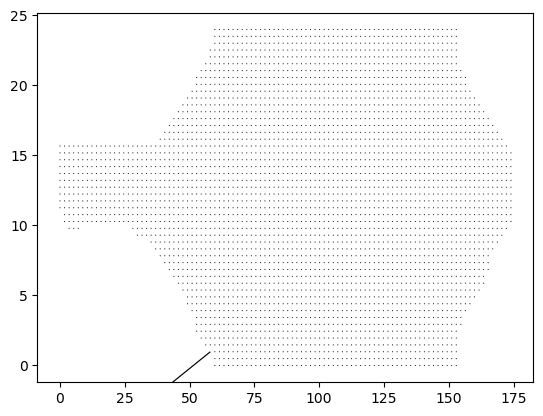

C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:36: RuntimeWarning: invalid value encountered in true_divide
  u_new = u_new/rho_new
C:\Users\caird\AppData\Local\Temp\ipykernel_16536\1666368539.py:37: RuntimeWarning: invalid value encountered in true_divide
  v_new = v_new/rho_new


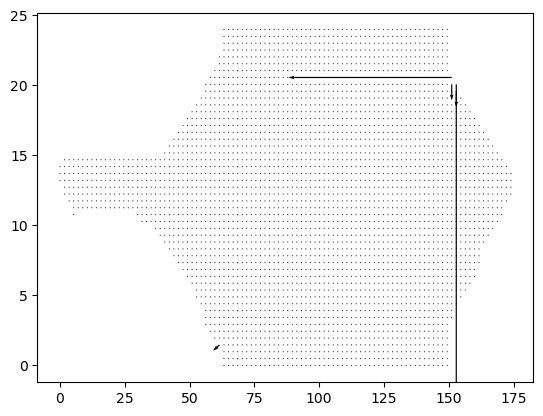

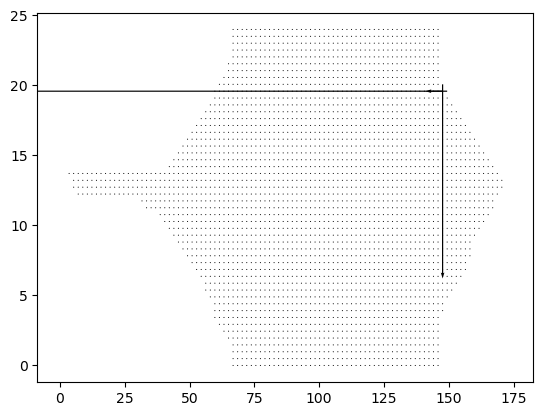

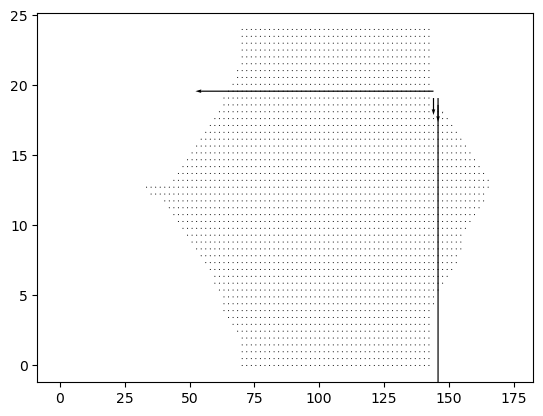

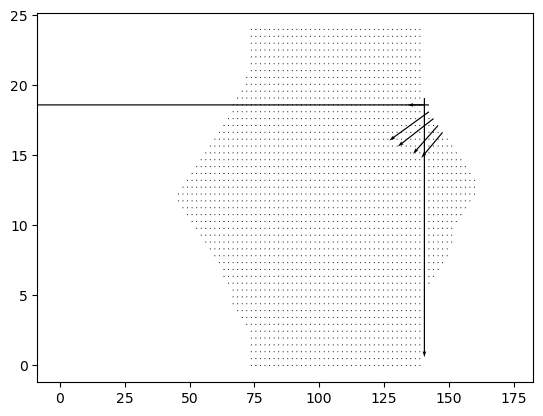

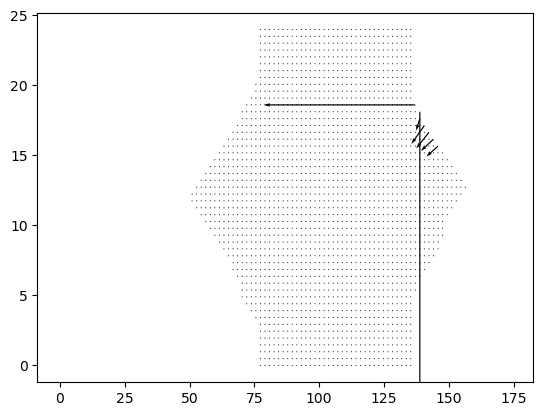

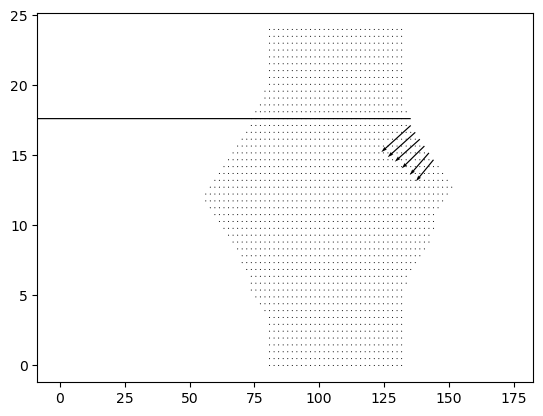

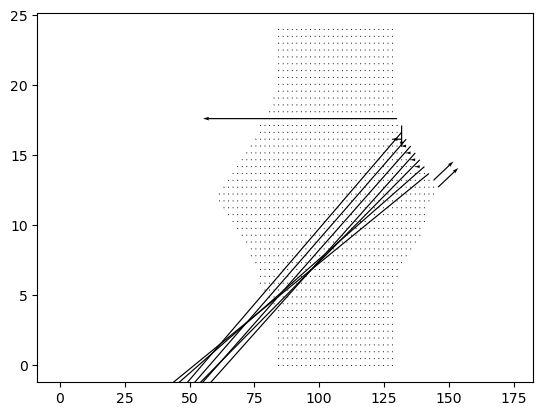

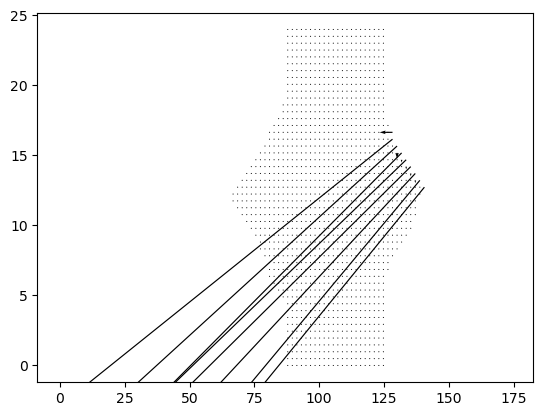

KeyboardInterrupt: 

In [237]:
main(1000, np.ones(np.shape(X)), u, v)